In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from datetime import timedelta

import n_sphere
import tqdm
from enflows.distributions import StandardNormal, Uniform, DiagonalNormal
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.transforms.lipschitz import LipschitzDenseNetBuilder, iResBlock
from enflows.nn.nets.activations import Sin
from enflows.nn.nets import ResidualNet
from enflows.flows.base import Flow
from enflows.transforms.injective import FixedNorm, ConstrainedAnglesSigmoid

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

def uniform_p_norm (beta):
    return torch.ones_like(beta)

In [4]:
def spherical_to_cartesian_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    
    assert arr.shape[1] >= 2
    r = arr[:, :1]
    angles = arr[:, 1:]
    
    sin_prods = torch.cumprod(torch.sin(angles), dim=1)
    x1 = r * torch.cos(angles[:, :1])
    xs = r * sin_prods[:, :-1] * torch.cos(angles[:, 1:])
    xn = r * sin_prods[:, -1:]

    return torch.cat((x1, xs, xn), dim=1)

def cartesian_to_spherical_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    assert arr.shape[1] >= 2
    radius = torch.linalg.norm(arr, dim=1)
    flipped_cumsum = torch.cumsum(torch.flip(arr ** 2, dims=(1,)), dim=1)
    sqrt_sums = torch.flip(torch.sqrt(flipped_cumsum), dims=(1,))[:,:-1]
    angles = torch.acos(arr[:, :-1] / sqrt_sums)
    last_angle = ((arr[:,-1] >= 0).float() * angles[:, -1] + \
                (arr[:,-1] < 0).float() * (2 * np.pi - angles[:, -1]))

    return torch.cat((radius.unsqueeze(1), angles[:, :-1], last_angle.unsqueeze(1)), dim=1)

In [5]:
def build_cond_flow_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])
    # low = torch.tensor(-1.).to(device)
    # high = torch.tensor(1.).to(device)
    # base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        #transformation_layers.append(RandomPermutation(features=flow_dim-1))

        
        
        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features, num_blocks=3, n_sigmoids=30)
            )
        )
        
        transformation_layers.append(
           InverseTransform(
               ActNorm(features=flow_dim-1)
           )
        )


    # transformation_layers.append(
    #    transforms.InverseTransform(
    #            ScalarScale(scale=5, trainable=False)
    #        )
    # )

    # transformation_layers.append(
    #    InverseTransform(
    #            CompositeTransform([
    #                Sigmoid(),
    #                ScalarScale(scale=20, trainable=False),
    #                ScalarShift(shift=-10, trainable=False)]
    #            )
    #        )
    # )
    
    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    
    transformation_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )

    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # combine into a flow
    flow = Flow(transform, base_dist).to(device)

    return flow

def build_cond_flow_lipshitz_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])

    densenet_builder = LipschitzDenseNetBuilder(input_channels=flow_dim-1,
                                                densenet_depth=5,
                                                activation_function=Sin(w0=30),
                                                lip_coeff=.97,
                                                )

    transform_layers = []
    for i in range(n_layers):
        transform_layers.append(InverseTransform(ActNorm(features=flow_dim-1)))
        transform_layers.append(InverseTransform(iResBlock(densenet_builder.build_network(), brute_force=False)))
    
    transform_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid()
            )
    )
    transform_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )

    transform_layers = transform_layers[::-1]
    transform = CompositeTransform(transform_layers)

    flow = Flow(transform, base_dist).to(device)

    return flow

In [6]:
def train_model(model, epochs=2_001, lr=1e-3, sample_size=1, device="cuda", **kwargs):

    # optimizer = torch.optim.Adam([{'params':model.parameters()}, {'params':log_sigma, 'lr':1e-2}], lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    loss = []
    try:
        start_time = time.monotonic()
        for epoch in range(epochs):
            model.train()
            
            optimizer.zero_grad()
            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size)
            if torch.any(torch.isnan(q_samples)): breakpoint()
            
            # log_lik = uniform_p_norm(beta=q_log_prob_beta)
            # kl_div = torch.mean(q_log_prob_beta - log_lik)
            # kl_div.backward()
            
            entropy = torch.mean(q_log_prob)
            entropy.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), .001)
            optimizer.step()

            # loss.append(torch.mean(q_log_prob_beta - log_lik).cpu().detach().numpy())
            loss.append(torch.mean(q_log_prob).cpu().detach().numpy())

            print(f"Training loss at step {epoch}: {loss[-1]:.4f}")
            if epoch % 25 == 0:
                
                # q_log_prob_np = q_log_prob.detach().cpu().numpy().ravel()
                # q_samples_np = q_samples.detach().cpu().numpy()
                # q_samples_theta_np = np.arctan2(q_samples_np[:,1], q_samples_np[:,0])
                # idx = np.argsort(q_log_prob_np)
                # print(q_log_prob_np[idx])
                # print(q_samples_theta_np[idx])
                # plt.scatter(q_samples_theta_np, q_log_prob_np, marker='.')
                # plt.show()
                
                q_log_prob_np = q_log_prob.detach().cpu().numpy().ravel()
                q_samples_np = q_samples.detach().cpu().numpy()
                samples_spherical = cartesian_to_spherical_torch(torch.tensor(q_samples_np)).numpy()
                for i in range(1, samples_spherical.shape[1]):
                    plt.figure(figsize=(10,5))
                    plt.scatter(samples_spherical[:,i], q_log_prob_np, marker='.')
                    plt.show()
                    
                # samples = sample_beta (flow, sample_size=10, n_iter=50, device=device)
                # samples = samples.reshape(-1,2)
                # plt.figure(figsize=(5,5))
                # plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.3)
                # plt.xlim(-1.1, 1.1)
                # plt.ylim(-1.1, 1.1)
                # ax = plt.gca()
                # ax.set_aspect('equal', adjustable='box')
                # plt.show()

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss


In [7]:
def sample_beta (model, sample_size=100, n_iter=500, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    samples = []
    for _ in tqdm.tqdm(range(n_iter)):
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size)
        samples.append(posterior_samples.cpu().detach().numpy())

    return np.concatenate(samples, 0)

In [8]:
def lp_norm(arr, p):
    norm = np.sum(np.power(np.abs(arr), p), 1)
    norm = np.power(norm, 1/p).reshape(-1,1)
    return arr/norm

def theta_given_x_y(arr):
    x_, y_ = arr[:,0], arr[:,1]
    theta_ = np.arctan2(y_,x_)
    return theta_

In [9]:
import os
dir_name = "./plots/"
if not os.path.exists(dir_name):
    # If it doesn't exist, create it
    os.makedirs(dir_name)

In [12]:
device = 'cuda'
set_random_seeds(1234)

# Build Model
flow_dim = 3
q = 1
norm = 1
flow = build_cond_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)

params = dict(lr=1e-3,
              epochs=201,
              sample_size=1_000,
              device=device)

torch.Size([1000, 3])
Training loss at step 0: -1.5583


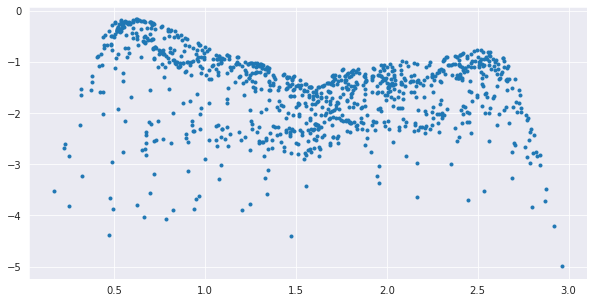

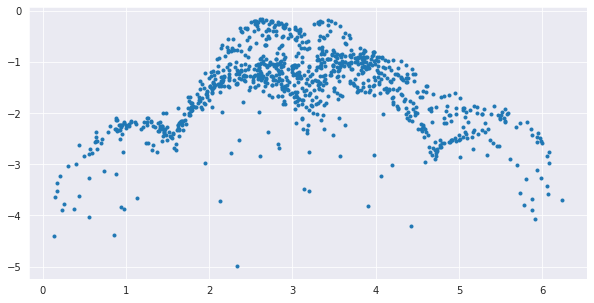

torch.Size([1000, 3])
Training loss at step 1: -1.6304
torch.Size([1000, 3])
interrupted..
Training took 0:00:07.574114 seconds


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): FixedNorm(
          (sph_to_cart_jac): SymPyModule(expressions=(-r*sin(theta_1), cos(theta_1), r*cos(theta_1), sin(theta_1)))
        )
      )
      (1): InverseTransform(
        (_transform): ConstrainedAnglesSigmoid(
          (elemwise_transform): CompositeTransform(
            (_transforms): ModuleList(
              (0): Sigmoid()
              (1): ScalarScale()
            )
          )
        )
      )
      (2): InverseTransform(
        (_transform): ActNorm()
      )
      (3): InverseTransform(
        (_transform): MaskedSumOfSigmoidsTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=2, out_features=64, bias=True)
            (blocks): ModuleList(
              (0): MaskedResidualBlock(
                (linear_layers): ModuleList(
                  (0): MaskedLinear(in_features=64, out_features=

In [13]:
flow, loss = train_model(flow, **params)
flow.eval()

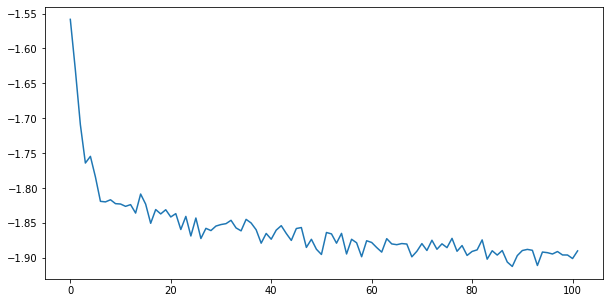

In [361]:
plt.figure(figsize=(10,5))
plt.plot(range(len(loss)), loss)
plt.show()

In [362]:
n_samples = 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples_reshaped = samples.reshape(-1, flow_dim)

100%|██████████| 20/20 [01:39<00:00,  4.95s/it]


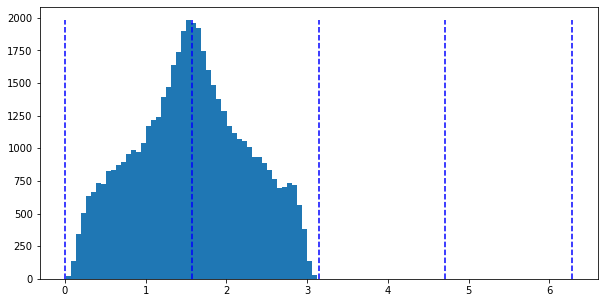

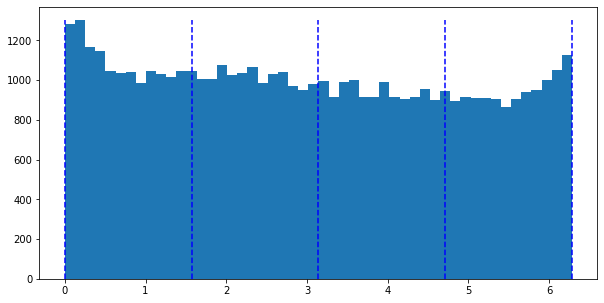

In [364]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(samples_[:n_samples_plot,0], samples_[:n_samples_plot,1], samples_[:n_samples_plot,2], marker='.', alpha=0.5)
# ax_min, ax_max = -1.1, 1.1
# ax.set_xlim3d(ax_min, ax_max)
# ax.set_ylim3d(ax_min, ax_max)
# ax.set_zlim3d(ax_min, ax_max)
# #plt.savefig(f"{dir_name}samples_p{q}_flow.pdf", dpi=100)
# plt.show()

samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
    plt.show()

In [357]:
from rpy2.robjects.packages import importr
rpgnorm = importr('pgnorm')
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


torch.Size([50000])
torch.Size([50000, 2])
torch.Size([50000])


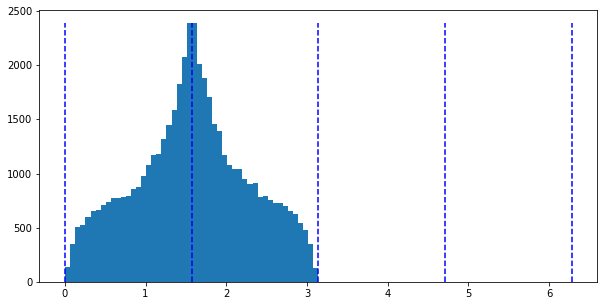

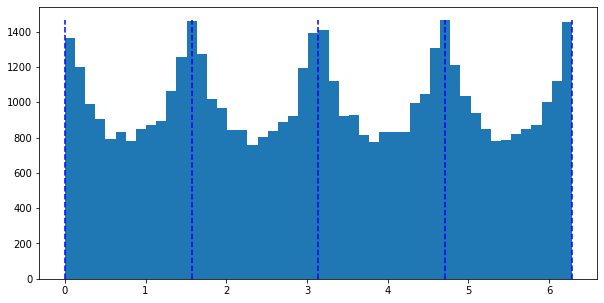

In [358]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(samples_norm[:n_samples_plot,0], samples_norm[:n_samples_plot,1], samples_norm[:n_samples_plot,2], marker='.', alpha=0.5)
# ax_min, ax_max = -1.1, 1.1
# ax.set_xlim3d(ax_min,ax_max)
# ax.set_ylim3d(ax_min,ax_max)
# ax.set_zlim3d(ax_min,ax_max)
# #ax = plt.gca()
# #ax.set_aspect('equal', adjustable='box')
# #plt.savefig(f"{dir_name}samples_p{q}_gt.pdf", dpi=100)
# plt.show()


samples_spherical = cartesian_to_spherical_torch(torch.from_numpy(samples_norm)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
    plt.show()

In [135]:
sol_2 = n_sphere.convert_rectangular(n_sphere.convert_spherical(samples_norm))

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


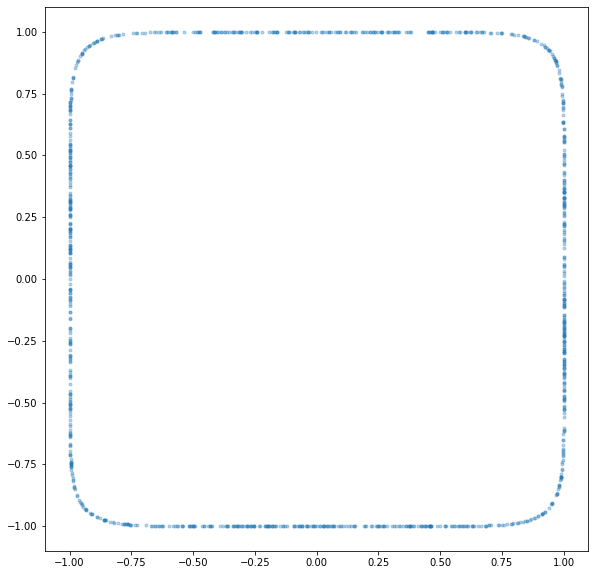

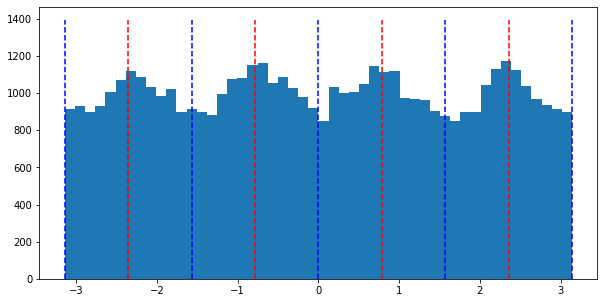

In [446]:
n_samples = 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples = samples.reshape(-1,2)
plt.figure(figsize=(10,10))
plt.scatter(samples[:n_samples_plot,0], samples[:n_samples_plot,1], marker='.', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"{dir_name}samples_p{q}_flow.pdf", dpi=100)
plt.show()

theta_ = theta_given_x_y(samples)
plt.figure(figsize=(10,5))
plt.hist(theta_, bins=50)
plt.vlines([-np.pi * 0.75, -np.pi * 0.25, np.pi * 0.25, np.pi * 0.75], ymin=0, ymax=max(n), linestyles='dashed', colors='r')
plt.vlines([-np.pi, -np.pi * 0.5, 0, np.pi * 0.5, np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
plt.show()

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


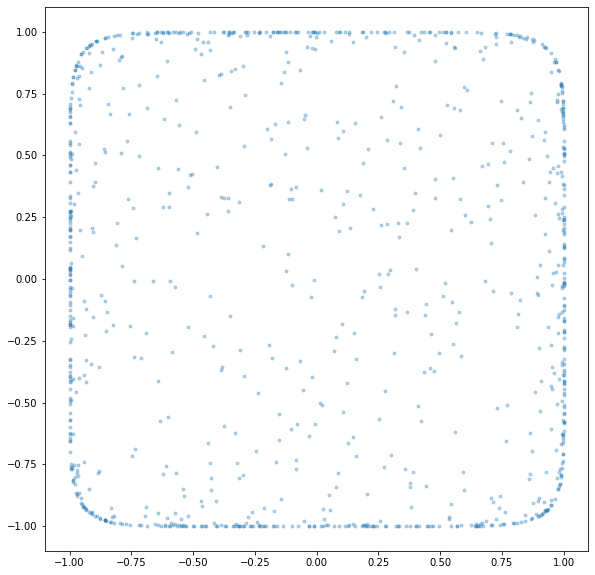

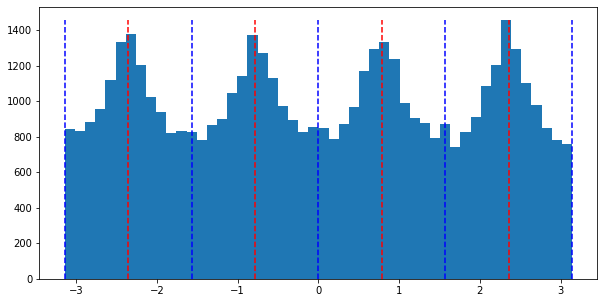

In [485]:
from rpy2.robjects.packages import importr
flow_dim = 3
rpgnorm = importr('pgnorm')
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)
plt.figure(figsize=(10,10))
plt.scatter(samples_norm[:n_samples_plot,0], samples_norm[:n_samples_plot,1], marker='.', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"{dir_name}samples_p{q}_gt.pdf", dpi=100)
plt.show()

plt.figure(figsize=(10,5))
theta_ = theta_given_x_y(samples_norm)
n, bins, patches = plt.hist(theta_, bins=50)
plt.vlines([-np.pi * 0.75, -np.pi * 0.25, np.pi * 0.25, np.pi * 0.75], ymin=0, ymax=max(n), linestyles='dashed', colors='r')
plt.vlines([-np.pi, -np.pi * 0.5, 0, np.pi * 0.5, np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
plt.show()